In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random as random
from functools import partial

from mm_sbi_review.examples.misspec_ma1 import assumed_dgp, calculate_summary_statistics, true_dgp

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sbi.inference import SNPE
from sbi.utils import BoxUniform
from scipy.stats import gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the prior over θ in [-1, 1]
prior = BoxUniform(low=torch.tensor([-1.0]), high=torch.tensor([1.0]))


In [5]:
np.random.seed(0)
key = random.PRNGKey(0)
num_sims = 100_000

# Generate random parameter values t1 in [-1, 1]
t1 = np.random.uniform(-1, 1, size=num_sims)

# Initialize an array to store summary statistics
n_obs = 100
x_full = np.zeros((num_sims, n_obs))
ssx = np.zeros((num_sims, 2))

# Simulate data and calculate summary statistics
for i in range(num_sims):
    key, subkey = random.split(key)
    data = assumed_dgp(subkey, t1[i])  # assumed_dgp function should accept t1[i]
    x_full[i, :] = data
    ssx[i] = calculate_summary_statistics(data)

# Calculate summary statistics for true data
key, subkey = random.split(key)
y = true_dgp(subkey)
ssy = calculate_summary_statistics(y)

In [6]:
"""Sample-based metrics between two statistical distributions."""

import jax.numpy as jnp
import numpy as np
from jaxtyping import Array
from scipy.spatial import KDTree  # type: ignore


def rbf_kernel(x, y, lengthscale=1.0):
    """Compute the RBF kernel between two sets of points."""
    return jnp.exp(-jnp.sum((x - y) ** 2) / (2 * lengthscale ** 2))


def median_heuristic(x, batch_size=1000):
    """Compute median heuristic using a batched approach to save memory."""
    n = x.shape[0]

    def batch_distances(i):
        start = i * batch_size
        end = min((i + 1) * batch_size, n)
        batch = x[start:end]
        dists = jnp.sqrt(jnp.sum((batch[:, None, :] - x[None, :, :]) ** 2,
                                 axis=-1))
        return dists.ravel()

    num_batches = (n + batch_size - 1) // batch_size
    all_dists = jnp.concatenate([batch_distances(i)
                                 for i in range(num_batches)])

    return jnp.sqrt(jnp.median(all_dists) / 2)  # NOTE: memory-intensive step


def unbiased_mmd(npe_posterior_samples: Array,
                 exact_posterior_samples: Array,
                 lengthscale: int = 1
                 ) -> Array:
    m = npe_posterior_samples.shape[0]
    n = exact_posterior_samples.shape[0]

    xx = jnp.sum(npe_posterior_samples**2, axis=1)[:, None]
    yy = jnp.sum(exact_posterior_samples**2, axis=1)[None, :]
    xy = jnp.dot(npe_posterior_samples, exact_posterior_samples.T)

    k_simulated = jnp.exp(-(xx + xx.T - 2 * jnp.dot(npe_posterior_samples,
                                                    npe_posterior_samples.T)) /
                          (2 * lengthscale**2))
    k_obs = jnp.exp(-(yy + yy.T - 2 * jnp.dot(exact_posterior_samples,
                                              exact_posterior_samples.T)) /
                    (2 * lengthscale**2))
    k_sim_obs = jnp.exp(-(xx + yy - 2 * xy) / (2 * lengthscale**2))

    k_simulated = k_simulated.at[jnp.diag_indices(m)].set(0)
    k_obs = k_obs.at[jnp.diag_indices(n)].set(0)

    k_sim_term = jnp.sum(k_simulated) / (m * (m-1))
    k_obs_term = jnp.sum(k_obs) / (n * (n-1))
    k_sim_obs_term = -2 * jnp.sum(k_sim_obs) / (m*n)

    mmd_value = k_sim_term + k_obs_term + k_sim_obs_term

    return mmd_value


def kullback_leibler(true_samples, sim_samples):
    """Compute the Kullback-Leibler divergence between two sets of samples.

    Args:
        true_samples (jax.Array): samples from the true distribution
        sim_samples (jax.Array): samples from the simulated distribution

    Returns:
        kl_estimate (float): estimate of the KL divergence

    See Pérez-Cruz (2008) "Kullback-Leibler divergence estimation of continuous
    distributions" for more details.
    """
    true_samples = np.array(true_samples)
    sim_samples = np.array(sim_samples)

    n, d = true_samples.shape
    m, _ = sim_samples.shape

    true_tree = KDTree(true_samples)
    sim_tree = KDTree(sim_samples)

    r = true_tree.query(true_samples,
                        k=2,  # num neighbours
                        eps=.01,  # (1+eps)-approximation upper bound
                        p=2  # p-norm
                        )[0][:, 1]  # skip first column as includes itself
    s = sim_tree.query(true_samples, k=1, eps=.01, p=2)[0]

    kl_estimate = -np.log(r/s).sum() * d / n + np.log(m / (n - 1.0))

    return kl_estimate

/Users/ryankelly/python_projects/mm_sbi_review/.venv/lib/python3.11/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [7]:
num_eps10 = int(num_sims * 0.10)
num_eps01 = int(num_sims * 0.01)


In [8]:
#Euclidean
distances = np.linalg.norm(x_full - y, axis=1)
sorted_indices = np.argsort(distances)
eps10_idx = sorted_indices[:num_eps10]
eps01_idx = sorted_indices[:num_eps01]
euclidean_samples = t1[eps01_idx]

In [9]:
thinning = 10
lengthscale = median_heuristic(jnp.vstack([ssy, ssx[::thinning]]))
lengthscale = lengthscale.item()
lengthscale


0.6195287108421326

In [ ]:
#MMD
mmd_vals = []
for i in range(num_sims):
    res = unbiased_mmd(x_full[i, :].reshape((-1, 1)), y.reshape((-1, 1)), lengthscale=lengthscale)
    mmd_vals.append(res)
mmd_vals = np.array(mmd_vals)
sorted_indices = np.argsort(mmd_vals)
eps10_idx = sorted_indices[:num_eps10]
eps01_idx = sorted_indices[:num_eps01]
mmd_samples = t1[eps01_idx]
t1[eps01_idx]


In [ ]:
# KL distance
kl_vals = []
for i in range(num_sims):
    res = kullback_leibler(y.reshape((-1, 1)), x_full[i, :].reshape((-1, 1)))
    kl_vals.append(res)
kl_vals = np.array(kl_vals)
sorted_indices = np.argsort(kl_vals)
eps10_idx = sorted_indices[:num_eps10]
eps01_idx = sorted_indices[:num_eps01]
kl_samples = t1[eps01_idx]


/var/folders/_z/ms2f3nmn0bb7wk4py9_pz7900000gp/T/ipykernel_28844/1790988847.py:93: RuntimeWarning: divide by zero encountered in divide
  kl_estimate = -np.log(r/s).sum() * d / n + np.log(m / (n - 1.0))


In [ ]:
print("bias euclidean", np.mean(euclidean_samples) - 0.)
print("bias mmd", np.mean(mmd_samples) - 0.)
print("bias kl", np.mean(kl_samples) - 0.)

bias euclidean -0.0065796730927708295
bias mmd 0.012283815450589135
bias kl 0.0110910831862438


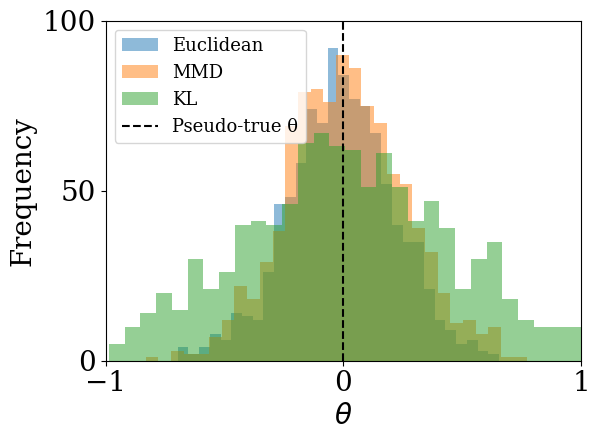

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Match LaTeX's default serif font
    "font.size": 20,  # Adjust font size to match main text
    "axes.labelsize": 20,  # Match axis label size
    "axes.titlesize": 20,  # Match title size
    "legend.fontsize": 13,  # Match legend font size
    "xtick.labelsize": 20,  # Match tick label size
    "ytick.labelsize": 20,  # Match tick label size
})


plt.hist(euclidean_samples, bins=30, alpha=0.5, label='Euclidean')
plt.hist(mmd_samples, bins=30, alpha=0.5, label='MMD')
plt.hist(kl_samples, bins=30, alpha=0.5, label='KL')
theta_pseudo_true = 0.0  # Adjust based on your context
plt.axvline(theta_pseudo_true, color='black', linestyle='--', label='Pseudo-true θ')
plt.xlim(-1, 1)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.xticks([-1, 0, 1])
plt.yticks([0, 50, 100])
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("figs/abc_losses.pdf")
plt.show()

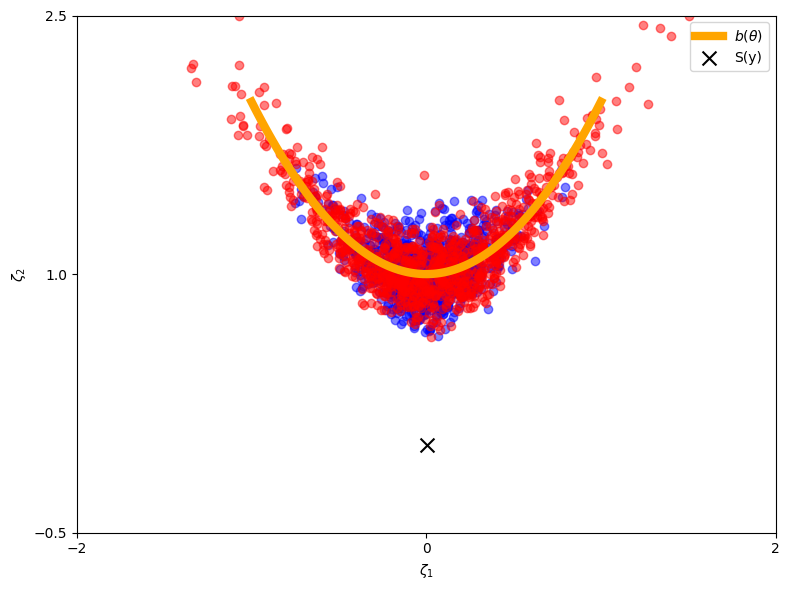

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot Posterior predictives for the three methods
# Posterior predictive simulations
samples_np = num_sims
num_posterior_samples = len(euclidean_samples)
num_pp_samples = 1_000  # Number of posterior predictive samples
thinning_interval = num_posterior_samples // num_pp_samples

# Initialize array to store summary statistics
x_pp_ss_euclidean = np.empty((num_pp_samples, 2))
x_pp_ss_kl = np.empty((num_pp_samples, 2))
x_pp_ss_mmd = np.empty((num_pp_samples, 2))

# Perform posterior predictive simulations
for i in range(num_pp_samples):
    idx = i * thinning_interval
    euclidean_theta = euclidean_samples[idx]
    kl_theta = kl_samples[idx]
    mmd_theta = mmd_samples[idx]
    key, subkey = random.split(key)
    x_sim = assumed_dgp(subkey, euclidean_theta, n_obs=100)  # Adjust n_obs as needed
    x_ss = calculate_summary_statistics(x_sim)
    x_pp_ss_euclidean[i, :] = x_ss
    
    key, subkey = random.split(key)
    x_sim = assumed_dgp(subkey, kl_theta, n_obs=100)  # Adjust n_obs as needed
    x_ss = calculate_summary_statistics(x_sim)
    x_pp_ss_kl[i, :] = x_ss

# Plot the joint distribution of summary statistics from posterior predictive simulations
plt.figure(figsize=(8, 6))
plt.scatter(x_pp_ss_euclidean[:, 1], x_pp_ss_euclidean[:, 0], c='blue', alpha=0.5)
plt.scatter(x_pp_ss_kl[:, 1], x_pp_ss_kl[:, 0], c='red', alpha=0.5)
def b_theta(t):
    return np.array([1 + t ** 2, t])

# Generate values for b_theta
t_vals = np.linspace(-1, 1, 101)
b_theta_vals = np.array([b_theta(t) for t in t_vals])

# prior_density = np.ones_like(theta_range) * 0.5  # Uniform density over [-1, 1]
plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=6)


# Plot the observed summary statistics
plt.scatter(ssy[1], ssy[0], color='black', marker='x', s=100, label='S(y)')

# Include the function b_theta for reference, if applicable
# plt.plot(b_theta_vals[:, 1], b_theta_vals[:, 0], color='orange', label=r'$b(\theta)$', linewidth=4)

# Set axis labels
plt.xlabel(r'$\zeta_1$')
plt.ylabel(r'$\zeta_2$')
plt.xlim(-2.0, 2.0)
plt.ylim(-0.5, 2.5)
plt.xticks([-2, 0, 2])
plt.yticks([-0.5, 1, 2.5])

# plt.title('Posterior Predictive Summary Statistics')
plt.legend()
plt.tight_layout()
# plt.savefig("figs/abc_losses_ppc.pdf")
plt.show()
plt.clf()